In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.notebook import tqdm

In [ ]:
# Path definitions
real = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/training_real/"
fake = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

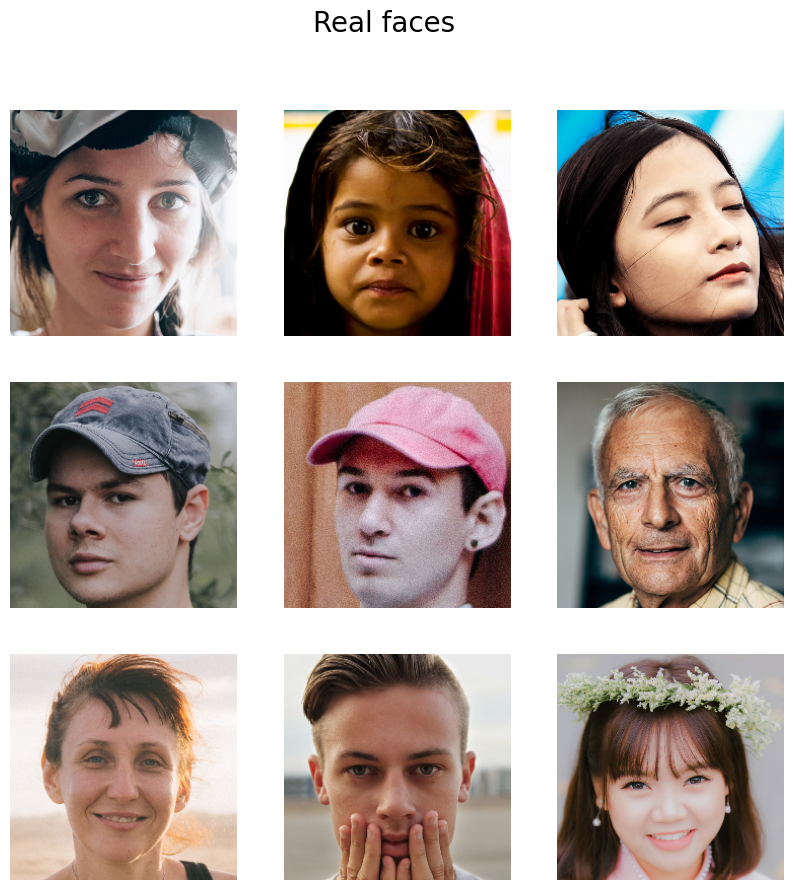

In [ ]:
# Plotting real faces
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')
plt.show()

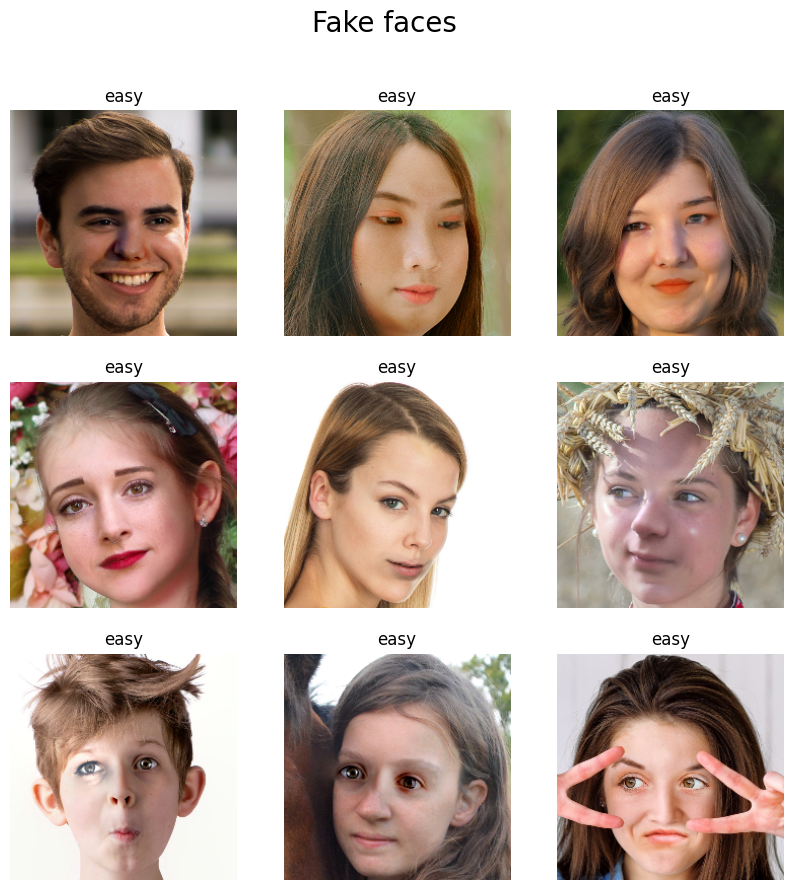

In [ ]:
# Plotting fake faces
fig = plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces", fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')
plt.show()

In [ ]:
dataset_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face"

In [ ]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2)

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=32,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=32,
                                          subset="validation")

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [ ]:
# Load InceptionV3 model
inception = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Model creation
tf.keras.backend.clear_session()

model = Sequential([
    inception,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.layers[0].trainable = False

In [ ]:
# Compile the model
opt = SGD(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization (Batch  (None, 5, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
def scheduler(epoch):
    if epoch <= 1:
        return 1.0
    elif epoch > 2 and epoch <= 10:
        return 0.1
    elif epoch > 10 and epoch <= 15:
        return 0.01
    else:
        return 0.001

lr_callbacks = LearningRateScheduler(scheduler)

In [ ]:
# Model training
hist = model.fit(train,
                 epochs=20,
                 callbacks=[lr_callbacks],
                 validation_data=val)

Epoch 1/20
52/52 [==============================] - 691s 13s/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4706 - lr: 1.0000
Epoch 2/20
52/52 [==============================] - 22s 420ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 1.0000
Epoch 3/20
52/52 [==============================] - 22s 423ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 22s 424ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 5/20
52/52 [==============================] - 22s 428ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 6/20
52/52 [==============================] - 22s 426ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 7/20
52/52 [==============================] - 22s 419ms/step - loss: nan - accuracy: 0.4703 - v

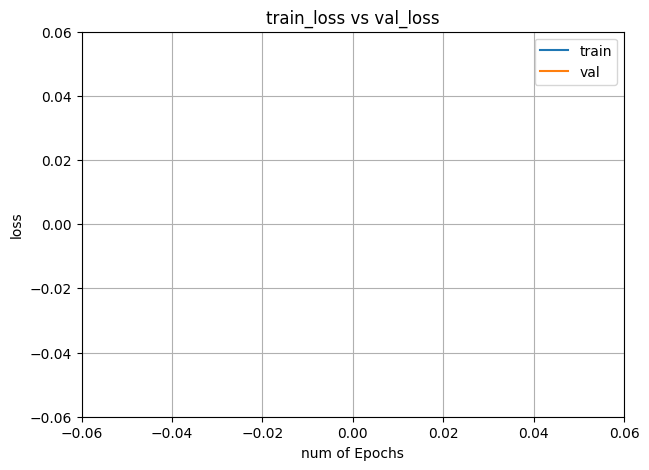

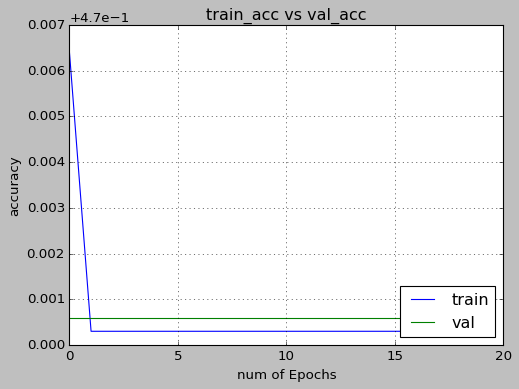

In [ ]:
# Plotting training history
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.style.use(['classic'])

In [18]:
# Making predictions
predictions = model.predict(val)

val_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/"

plt.figure(figsize=(15, 15))
start_index = 300

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    preds = int(predictions[start_index+i][0] > 0.5)
    gt = val.filenames[start_index+i][9:13]

    gt = 0 if gt == "fake" else 1

    col = "r" if preds != gt else "g"
    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, preds, gt), color=col)
    plt.imshow(load_img(val_path+val.filenames[start_index+i]))
    plt.tight_layout()

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [17]:
model.save('/content/drive/MyDrive/inceptionV3Deepfake_model.h5')
print("Model saved as 'hybrid_inception_lstm_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'hybrid_inception_lstm_model.h5'
